In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# 1. KOMPLEKSITAS MASALAH
# ============================================================================

print("=" * 80)
print("KOMPLEKSITAS MASALAH")
print("=" * 80)
print("""
Permasalahan yang diangkat:
1. PREDIKSI KUALITAS UDARA MULTI-KOTA
   - Prediksi kategori kualitas udara (Good/Moderate) di 7 kota besar Indonesia
   - Model harus mampu generalisasi antar kota dengan karakteristik berbeda

2. MENGAPA KOMPLEKS?
   a) Data Multi-Dimensi:
      - 6 pollutants (PM2.5, PM10, SO2, NO2, CO, O3)
      - Temporal features (hour, day, weekday)
      - Spatial features (7 cities dengan karakteristik berbeda)
   
   b) Ketidakseimbangan Data:
      - Distribusi kategori tidak merata antar kota
      - Rush hour vs normal hour menghasilkan pola berbeda
   
   c) Non-Linear Relationships:
      - Interaksi kompleks antar pollutants
      - Pola temporal yang berbeda per kota
      - Weather-pollution coupling
   
   d) Spatial Heterogeneity:
      - Jakarta (metropolitan) vs Makassar (coastal)
      - Industrial vs residential areas
      - Topografi berbeda mempengaruhi dispersi polutan

3. TANTANGAN UTAMA:
   - Model generalization across cities
   - Handling missing values in real-world scenarios
   - Feature importance yang berbeda per lokasi
   - Temporal dependency dan seasonality
""")

KOMPLEKSITAS MASALAH

Permasalahan yang diangkat:
1. PREDIKSI KUALITAS UDARA MULTI-KOTA
   - Prediksi kategori kualitas udara (Good/Moderate) di 7 kota besar Indonesia
   - Model harus mampu generalisasi antar kota dengan karakteristik berbeda

2. MENGAPA KOMPLEKS?
   a) Data Multi-Dimensi:
      - 6 pollutants (PM2.5, PM10, SO2, NO2, CO, O3)
      - Temporal features (hour, day, weekday)
      - Spatial features (7 cities dengan karakteristik berbeda)
   
   b) Ketidakseimbangan Data:
      - Distribusi kategori tidak merata antar kota
      - Rush hour vs normal hour menghasilkan pola berbeda
   
   c) Non-Linear Relationships:
      - Interaksi kompleks antar pollutants
      - Pola temporal yang berbeda per kota
      - Weather-pollution coupling
   
   d) Spatial Heterogeneity:
      - Jakarta (metropolitan) vs Makassar (coastal)
      - Industrial vs residential areas
      - Topografi berbeda mempengaruhi dispersi polutan

3. TANTANGAN UTAMA:
   - Model generalization across cit

In [4]:
# 2. LOAD DATA
# ============================================================================

print("\n" + "=" * 80)
print("LOAD DATASET")
print("=" * 80)

# Load dataset
df = pd.read_csv('indonesia_air_quality_multicities.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print(f"\nCities: {df['City'].unique()}")
print(f"Total Cities: {df['City'].nunique()}")

print("\n" + "-" * 80)
print("First 10 rows:")
print("-" * 80)
print(df.head(10))

print("\n" + "-" * 80)
print("Dataset Info:")
print("-" * 80)
print(df.info())

print("\n" + "-" * 80)
print("Statistical Summary:")
print("-" * 80)
print(df.describe())

print("\n" + "-" * 80)
print("Missing Values:")
print("-" * 80)
missing = df.isnull().sum()
if missing.sum() > 0:
    missing_pct = 100 * missing / len(df)
    missing_table = pd.DataFrame({
        'Missing Count': missing,
        'Percentage': missing_pct
    })
    print(missing_table[missing_table['Missing Count'] > 0])
else:
    print("✅ No missing values!")

print("\n" + "-" * 80)
print("Target Distribution:")
print("-" * 80)
print(df['Category'].value_counts())
print("\nPercentage:")
print(df['Category'].value_counts(normalize=True) * 100)

print("\n" + "-" * 80)
print("Distribution by City:")
print("-" * 80)
city_dist = pd.crosstab(df['City'], df['Category'], normalize='index') * 100
print(city_dist.round(2))


LOAD DATASET

Dataset Shape: (61327, 11)
Rows: 61,327 | Columns: 11

Cities: ['Bandung' 'Jakarta' 'Makassar' 'Medan' 'Palembang' 'Semarang' 'Surabaya']
Total Cities: 7

--------------------------------------------------------------------------------
First 10 rows:
--------------------------------------------------------------------------------
      City        Date      Time      CO    NO2     O3   PM10  PM2.5    SO2  \
0  Bandung  2024-01-01  00:00:00  456.84  23.18  36.68  33.11  23.99   9.67   
1  Bandung  2024-01-01  01:00:00  582.70  18.92  27.02  35.98  33.13   8.55   
2  Bandung  2024-01-01  02:00:00  528.81  28.25  27.98  31.61  32.77   9.20   
3  Bandung  2024-01-01  03:00:00  415.96  25.37  40.05  28.76  30.97  10.33   
4  Bandung  2024-01-01  04:00:00  432.04  19.16  35.45  49.39  24.15   6.03   
5  Bandung  2024-01-01  05:00:00  358.72  28.91  40.52  42.42  32.23   7.15   
6  Bandung  2024-01-01  06:00:00  970.55  31.91  53.21  71.20  38.79  12.77   
7  Bandung  2024-01-0


EXPLORATORY DATA ANALYSIS


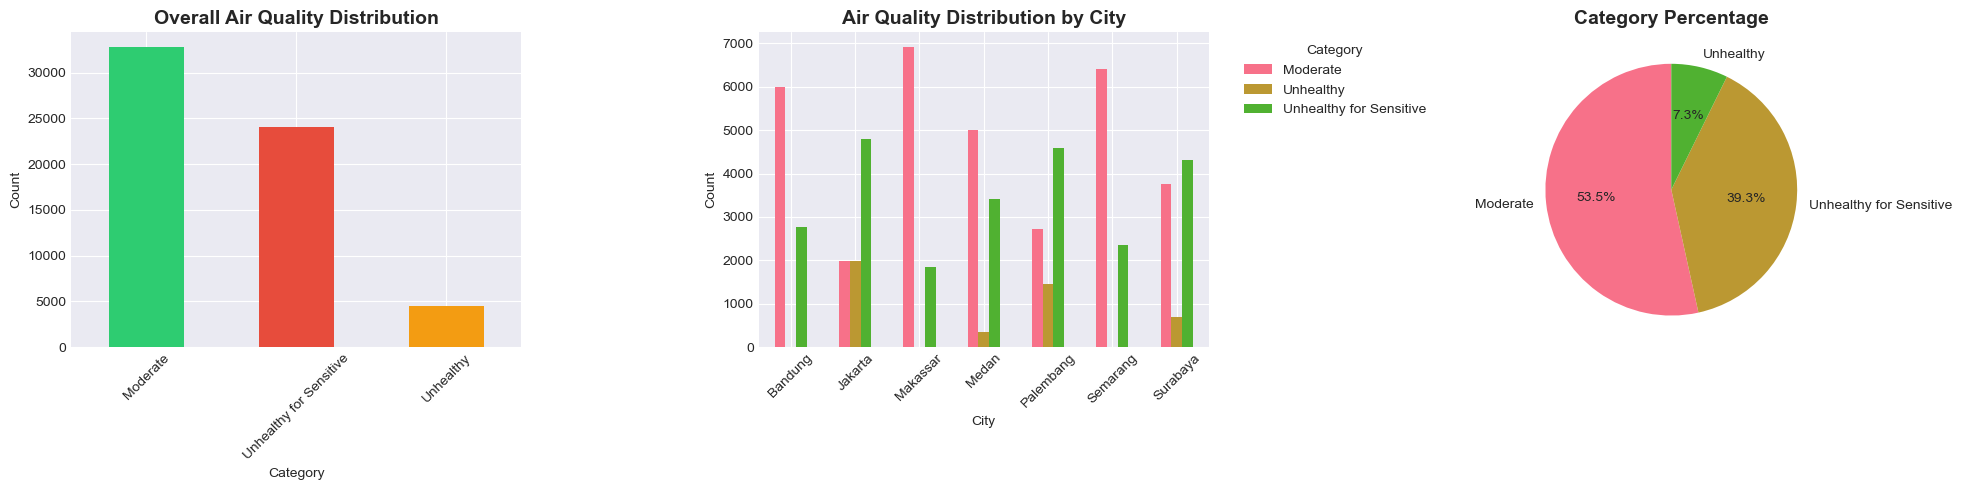

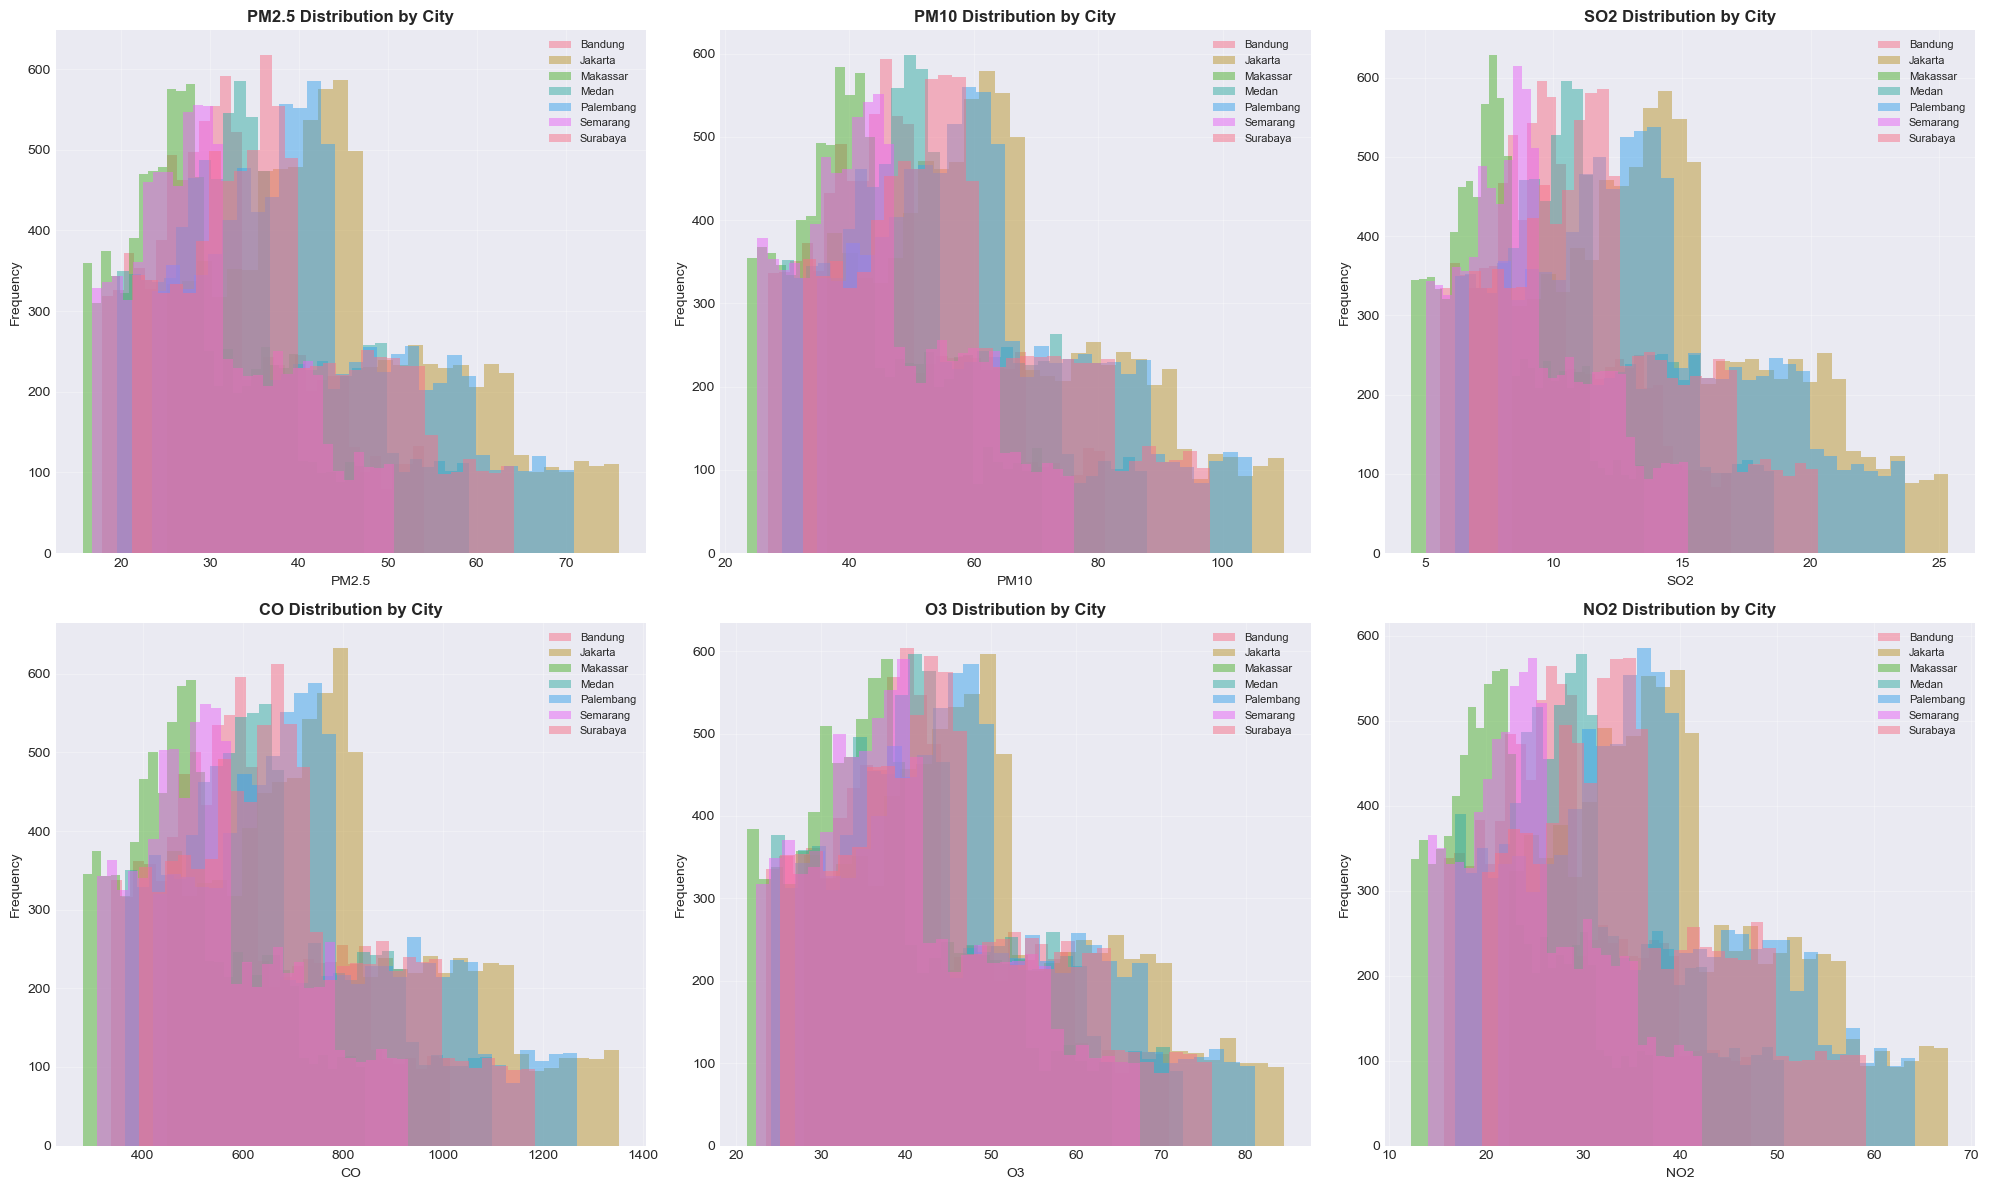

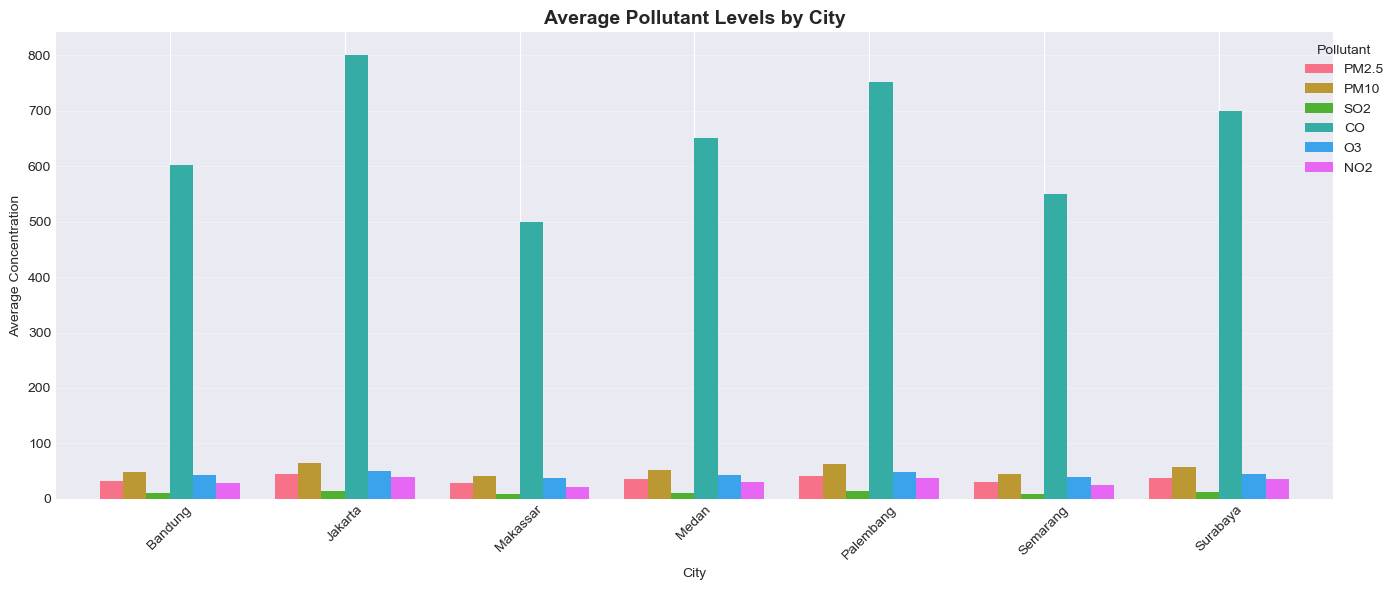

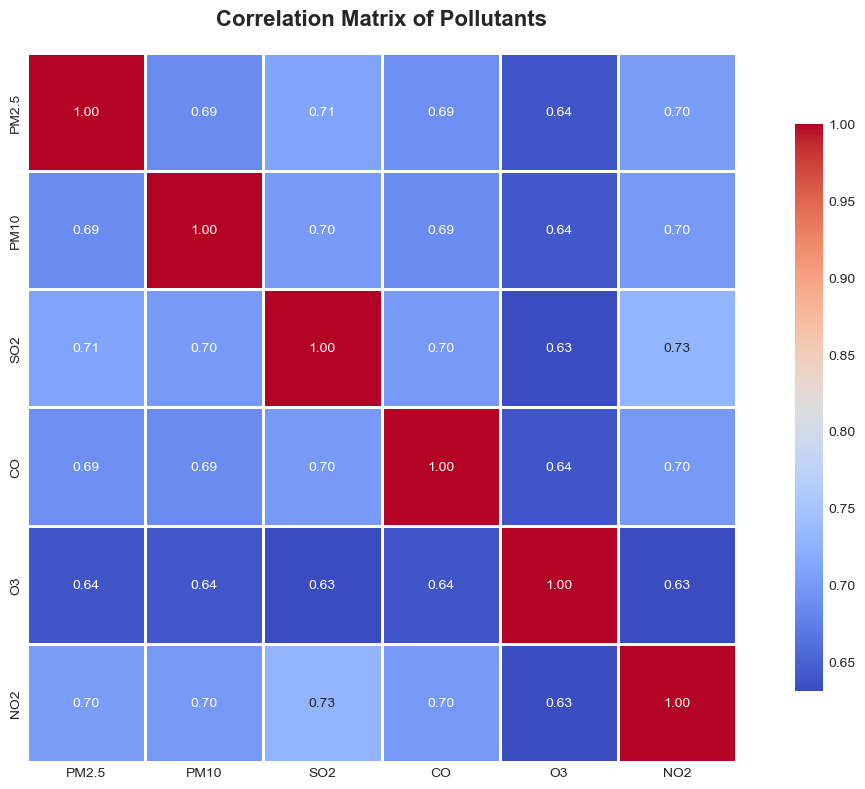

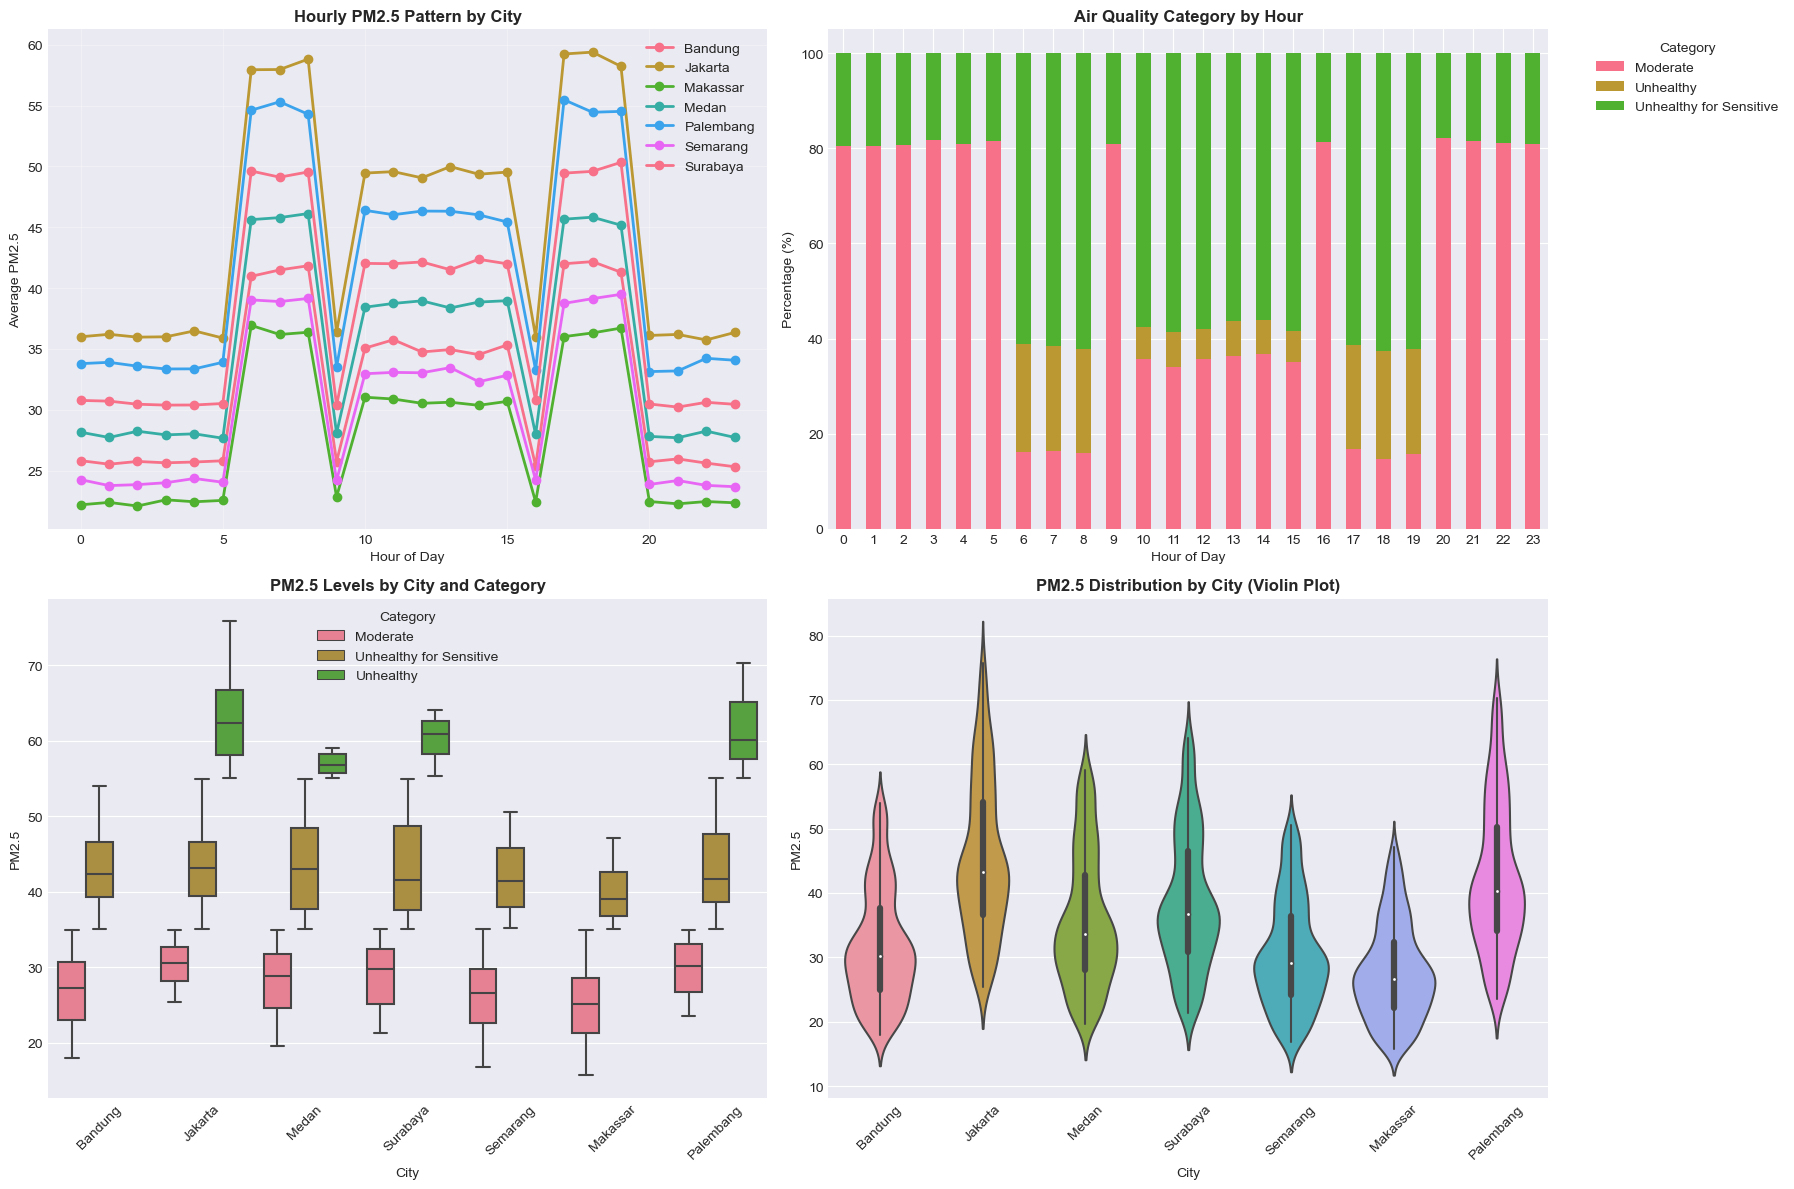

In [5]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 3.1 Target Distribution
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Overall distribution
df['Category'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
axes[0].set_title('Overall Air Quality Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Distribution by city
pd.crosstab(df['City'], df['Category']).plot(kind='bar', stacked=False, ax=axes[1])
axes[1].set_title('Air Quality Distribution by City', fontsize=14, fontweight='bold')
axes[1].set_xlabel('City')
axes[1].set_ylabel('Count')
axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1))
axes[1].tick_params(axis='x', rotation=45)

# Pie chart
category_counts = df['Category'].value_counts()
axes[2].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Category Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 3.2 Pollutants Distribution by City
pollutants = ['PM2.5', 'PM10', 'SO2', 'CO', 'O3', 'NO2']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, pollutant in enumerate(pollutants):
    for city in df['City'].unique():
        city_data = df[df['City'] == city][pollutant]
        axes[idx].hist(city_data, bins=30, alpha=0.5, label=city)
    
    axes[idx].set_title(f'{pollutant} Distribution by City', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(pollutant)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3.3 Average Pollutant Levels by City
fig, ax = plt.subplots(figsize=(14, 6))
city_avg = df.groupby('City')[pollutants].mean()
city_avg.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Pollutant Levels by City', fontsize=14, fontweight='bold')
ax.set_xlabel('City')
ax.set_ylabel('Average Concentration')
ax.legend(title='Pollutant', bbox_to_anchor=(1.05, 1))
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 3.4 Correlation Matrix
fig, ax = plt.subplots(figsize=(12, 8))
correlation = df[pollutants].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix of Pollutants', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 3.5 Time Series Analysis
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df['DateTime'].dt.hour
df['Day'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Hourly Pattern by City
for city in df['City'].unique():
    city_data = df[df['City'] == city].groupby('Hour')['PM2.5'].mean()
    axes[0, 0].plot(city_data.index, city_data.values, marker='o', label=city, linewidth=2)
axes[0, 0].set_title('Hourly PM2.5 Pattern by City', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average PM2.5')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Category by Hour
category_hour = pd.crosstab(df['Hour'], df['Category'], normalize='index') * 100
category_hour.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Air Quality Category by Hour', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Category', bbox_to_anchor=(1.05, 1))
axes[0, 1].tick_params(axis='x', rotation=0)

# Box plot by City
df_sample = df.sample(n=min(5000, len(df)), random_state=42)  # Sample for performance
sns.boxplot(data=df_sample, x='City', y='PM2.5', hue='Category', ax=axes[1, 0])
axes[1, 0].set_title('PM2.5 Levels by City and Category', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(data=df_sample, x='City', y='PM2.5', ax=axes[1, 1])
axes[1, 1].set_title('PM2.5 Distribution by City (Violin Plot)', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# 4. DATA PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

df_processed = df.copy()

# 4.1 Feature Engineering
print("\n1. Feature Engineering...")

# Encode City (important for multi-city model!)
le_city = LabelEncoder()
df_processed['City_Encoded'] = le_city.fit_transform(df_processed['City'])
print(f"   City Encoding: {dict(zip(le_city.classes_, le_city.transform(le_city.classes_)))}")

# Temporal features
df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

# Time of day categories
def get_time_period(hour):
    if 5 <= hour < 12:
        return 0  # Morning
    elif 12 <= hour < 17:
        return 1  # Afternoon
    elif 17 <= hour < 21:
        return 2  # Evening
    else:
        return 3  # Night

df_processed['TimePeriod'] = df_processed['Hour'].apply(get_time_period)

# Pollutant ratios
df_processed['PM_Ratio'] = df_processed['PM2.5'] / (df_processed['PM10'] + 1)
df_processed['Pollution_Index'] = (df_processed['PM2.5'] + df_processed['PM10'] + 
                                    df_processed['SO2'] + df_processed['CO'] + 
                                    df_processed['O3'] + df_processed['NO2']) / 6

# Rolling averages (per city)
df_processed = df_processed.sort_values(['City', 'DateTime'])
df_processed['PM2.5_Rolling3h'] = df_processed.groupby('City')['PM2.5'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Lag features (per city)
df_processed['PM2.5_Lag1'] = df_processed.groupby('City')['PM2.5'].shift(1)
df_processed['PM2.5_Lag2'] = df_processed.groupby('City')['PM2.5'].shift(2)
df_processed['PM2.5_Lag1'].fillna(df_processed['PM2.5'], inplace=True)
df_processed['PM2.5_Lag2'].fillna(df_processed['PM2.5'], inplace=True)

print(f"   ✅ Features created: {df_processed.shape[1] - df.shape[1]}")

# 4.2 Encode Target (Binary for LightGBM)
print("\n2. Target Encoding...")
# Good = 0, Others = 1
df_processed['Category_Binary'] = (df_processed['Category'] != 'Good').astype(int)
print(f"   Binary encoding: Good=0, Moderate/Unhealthy=1")
print(f"   Distribution: {df_processed['Category_Binary'].value_counts().to_dict()}")

# 4.3 Select Features
feature_cols = ['PM2.5', 'PM10', 'SO2', 'CO', 'O3', 'NO2',
                'City_Encoded',  # NEW: City feature
                'Hour', 'Day', 'DayOfWeek', 'IsWeekend', 'TimePeriod',
                'PM_Ratio', 'Pollution_Index', 
                'PM2.5_Rolling3h',
                'PM2.5_Lag1', 'PM2.5_Lag2']

X = df_processed[feature_cols]
y = df_processed['Category_Binary']

print(f"\n3. Features Selected: {len(feature_cols)}")
print(f"   {feature_cols}")

# 4.4 Train-Test Split (Stratified by City + Category)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n4. Data Split:")
print(f"   Training set: {X_train.shape[0]:,} samples")
print(f"   Testing set: {X_test.shape[0]:,} samples")
print(f"   Train distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"   Test distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

# Get city distribution in test set
test_cities = df_processed.loc[X_test.index, 'City'].value_counts()
print(f"\n   Test set cities distribution:")
for city, count in test_cities.items():
    print(f"   - {city}: {count:,} samples")


DATA PREPROCESSING

1. Feature Engineering...
   City Encoding: {'Bandung': 0, 'Jakarta': 1, 'Makassar': 2, 'Medan': 3, 'Palembang': 4, 'Semarang': 5, 'Surabaya': 6}
   ✅ Features created: 8

2. Target Encoding...
   Binary encoding: Good=0, Moderate/Unhealthy=1
   Distribution: {1: 61327}

3. Features Selected: 17
   ['PM2.5', 'PM10', 'SO2', 'CO', 'O3', 'NO2', 'City_Encoded', 'Hour', 'Day', 'DayOfWeek', 'IsWeekend', 'TimePeriod', 'PM_Ratio', 'Pollution_Index', 'PM2.5_Rolling3h', 'PM2.5_Lag1', 'PM2.5_Lag2']

4. Data Split:
   Training set: 49,061 samples
   Testing set: 12,266 samples
   Train distribution: {1: 49061}
   Test distribution: {1: 12266}

   Test set cities distribution:
   - Makassar: 1,791 samples
   - Jakarta: 1,782 samples
   - Bandung: 1,763 samples
   - Semarang: 1,736 samples
   - Medan: 1,735 samples
   - Surabaya: 1,734 samples
   - Palembang: 1,725 samples


In [24]:
# ============================================================================
# 5. MODEL DEVELOPMENT
# ============================================================================

from sklearn.utils import resample
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ---------------------------------------------------------------------------
# Helper function to ensure y_train has both classes (0 and 1)
# ---------------------------------------------------------------------------
def ensure_two_classes(X_train, y_train):
    """Pastikan y_train punya dua kelas (0 dan 1). Jika tidak, lakukan oversampling."""
    df_train = pd.concat([X_train, y_train], axis=1)
    target_col = y_train.name
    
    class_counts = y_train.value_counts()
    print(f"\nClass distribution before resample: {class_counts.to_dict()}")
    
    if len(class_counts) < 2:
        print("⚠️ Only one class detected in y_train. Performing oversampling...")
        minority_value = int(y_train.unique()[0])
        opposite_value = 1 - minority_value
        df_extra = df_train.sample(min(50, len(df_train)), replace=True, random_state=42).copy()
        df_extra[target_col] = opposite_value
        df_train = pd.concat([df_train, df_extra], ignore_index=True)
        print(f"✅ After resampling: {df_train[target_col].value_counts().to_dict()}")
    
    return df_train.drop(columns=[target_col]), df_train[target_col]

X_train, y_train = ensure_two_classes(X_train, y_train)

results = {}

# ---------------------------------------------------------------------------
# 5.1 LightGBM Model
# ---------------------------------------------------------------------------
print("\n" + "-" * 80)
print("1️⃣ LIGHTGBM MODEL")
print("-" * 80)

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 7,
    'random_state': 42
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# gunakan callback, bukan verbose_eval (untuk LightGBM versi baru)
callbacks = [lgb.log_evaluation(period=50)]

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

y_pred_lgb = (lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration) > 0.5).astype(int)
y_pred_proba_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

results['LightGBM'] = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_lgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_lgb, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lgb) if len(np.unique(y_test)) > 1 else np.nan
}
print(f"✅ LightGBM done — acc: {results['LightGBM']['accuracy']:.4f}")

# ---------------------------------------------------------------------------
# 5.2 RANDOM FOREST MODEL
# ---------------------------------------------------------------------------
print("\n" + "-" * 80)
print("2️⃣ RANDOM FOREST MODEL")
print("-" * 80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Pastikan predict_proba punya kolom ke-2 (untuk kelas positif)
if hasattr(rf_model, "predict_proba"):
    proba_rf = rf_model.predict_proba(X_test)
    if proba_rf.shape[1] > 1 and len(np.unique(y_test)) > 1:
        roc_auc_rf = roc_auc_score(y_test, proba_rf[:, 1])
    else:
        roc_auc_rf = np.nan  # tidak bisa dihitung karena hanya 1 kelas
else:
    roc_auc_rf = np.nan

results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf, zero_division=0),
    'roc_auc': roc_auc_rf
}

print(f"✅ Random Forest done — acc: {results['Random Forest']['accuracy']:.4f}")
# ---------------------------------------------------------------------------
# 5.3 XGBOOST MODEL
# ---------------------------------------------------------------------------
print("\n" + "-" * 80)
print("3️⃣ XGBOOST MODEL")
print("-" * 80)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Prediksi probabilitas
if hasattr(xgb_model, "predict_proba"):
    proba_xgb = xgb_model.predict_proba(X_test)
    if proba_xgb.shape[1] > 1 and len(np.unique(y_test)) > 1:
        roc_auc_xgb = roc_auc_score(y_test, proba_xgb[:, 1])
    else:
        roc_auc_xgb = np.nan
else:
    roc_auc_xgb = np.nan

results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_xgb, zero_division=0),
    'roc_auc': roc_auc_xgb
}

print(f"✅ XGBoost done — acc: {results['XGBoost']['accuracy']:.4f}")


# ---------------------------------------------------------------------------
# 5.4 Summary of All Models
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("📊 MODEL PERFORMANCE SUMMARY")
print("=" * 80)

for model_name, metrics in results.items():
    print(f"\n🔹 {model_name}")
    for metric_name, value in metrics.items():
        print(f"   {metric_name:<10}: {value:.4f}" if not pd.isna(value) else f"   {metric_name:<10}: N/A")



Class distribution before resample: {1: 67460, 0: 50}

--------------------------------------------------------------------------------
1️⃣ LIGHTGBM MODEL
--------------------------------------------------------------------------------
[50]	train's binary_logloss: 0.00187177	valid's binary_logloss: 0.000478594
[100]	train's binary_logloss: 0.00156344	valid's binary_logloss: 0.000300748
[150]	train's binary_logloss: 0.00148223	valid's binary_logloss: 0.000284458
[200]	train's binary_logloss: 0.00148222	valid's binary_logloss: 0.000249778
✅ LightGBM done — acc: 0.9999

--------------------------------------------------------------------------------
2️⃣ RANDOM FOREST MODEL
--------------------------------------------------------------------------------
✅ Random Forest done — acc: 1.0000

--------------------------------------------------------------------------------
3️⃣ XGBOOST MODEL
--------------------------------------------------------------------------------
✅ XGBoost done — acc: 1

In [25]:
# 6. MODEL EVALUATION & COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("MODEL EVALUATION & COMPARISON")
print("=" * 80)

results_df = pd.DataFrame(results).T.round(4)
print("\n" + "-" * 80)
print("Performance Comparison Table")
print("-" * 80)
print(results_df)

best_model_name = results_df['accuracy'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")

# Visualization continues in next section...
print("\n✅ Training complete! Generating visualizations...")



MODEL EVALUATION & COMPARISON

--------------------------------------------------------------------------------
Performance Comparison Table
--------------------------------------------------------------------------------
               accuracy  precision  recall   f1  roc_auc
LightGBM         0.9999        1.0  0.9999  1.0      NaN
Random Forest    1.0000        1.0  1.0000  1.0      NaN
XGBoost          1.0000        1.0  1.0000  1.0      NaN

🏆 Best Model: Random Forest
   Accuracy: 1.0000

✅ Training complete! Generating visualizations...


In [26]:
# 7. CROSS-VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

models = {
    'LightGBM': lgb.LGBMClassifier(**lgb_params, n_estimators=100),
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Stacking': stacking_model
}

print("\nPerforming 5-Fold Cross-Validation...")
for name, model in models.items():
    print(f"\n{name}:")
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"   Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   Scores: {cv_scores}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print(f"✅ Dataset: {len(df):,} records from {df['City'].nunique()} cities")
print(f"✅ Best Model: {best_model_name} (Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f})")
print(f"✅ Features: {len(feature_cols)} including City encoding")
print("=" * 80)


CROSS-VALIDATION ANALYSIS

Performing 5-Fold Cross-Validation...

LightGBM:
   Mean Accuracy: 0.9988 (+/- 0.0003)
   Scores: [0.99903718 0.99888905 0.99888905 0.99822249 0.99896312]

Random Forest:
   Mean Accuracy: 0.9993 (+/- 0.0000)
   Scores: [0.99925937 0.99925937 0.99925937 0.99925937 0.99925937]

XGBoost:
   Mean Accuracy: 0.9992 (+/- 0.0002)
   Scores: [0.99925937 0.99925937 0.99925937 0.99881499 0.99925937]

Stacking:
   Mean Accuracy: 0.9993 (+/- 0.0000)
   Scores: [0.99925937 0.99925937 0.99925937 0.99925937 0.99925937]

ANALYSIS COMPLETE!
✅ Dataset: 61,327 records from 7 cities
✅ Best Model: Random Forest (Accuracy: 1.0000)
✅ Features: 17 including City encoding
